**Data 612: Project 3 - Matrix Factorization Methods<br>Christina Valore, Juliann McEachern, & Rajwant Mishra<br>Due: June 25, 2019**

<h1 align="center">Goodreads Recommender Systems</h1>

<h2 style="color:#088A68;">Getting Started</h2>

For project 3, we choose to continue our work with Goodreads books and build a recommender system that utilizes implicit matrix factorization techniques. As we have learned, singular value decomposition (SVD) matrices can be computationally expensive. Thus, our work will focus on a small subset of Goodreads book data that we previously explored in [Project 2](https://nbviewer.jupyter.org/github/jemceach/612-group/blob/master/project-2/report.ipynb). 

We will also compare the performance of our functions and calculations to the results generated by the `surprise` package. 

#### Python Dependencies

In [70]:
# The usual suspects 
import numpy as np, pandas as pd 

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# Scikits packages
## Suprise!
from surprise.model_selection import train_test_split
from surprise import KNNWithMeans, SVD, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split

## TFIDF
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer


#### Data Preparation  

Data was loaded from our Project 2 repository collection of Goodread books, ratings, and tags. Tranformations then were used to combine the dataframes. 

In [2]:
# Load data into respective frames
books = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/books.csv',memory_map=True,engine='c', usecols=['goodreads_book_id','book_id', 'title', 'authors'])
ratings = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/ratings.tar.gz', 
                      compression='gzip', usecols=['user_id','book_id', 'rating'],memory_map=True,engine='c',skiprows=[5976480])
tags = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/book_tags.csv', engine='c', usecols=['goodreads_book_id','tag_id'],memory_map=True)
tag_id = pd.read_csv('https://raw.githubusercontent.com/jemceach/612-group/master/project-2/data/tags.csv',memory_map=True,engine='c')

# transformations to join dataframes
book_tags = tags.set_index('tag_id').join(tag_id.set_index('tag_id')).merge(books, on='goodreads_book_id', how="inner")
data = ratings.set_index('book_id').join(books.set_index('book_id')).drop('goodreads_book_id', axis=1).reset_index()

In [3]:
# preview data 
data.head()

book_id  user_id  rating          authors  \
0        1     2886       5  Suzanne Collins   
1        1     6158       5  Suzanne Collins   
2        1     3991       4  Suzanne Collins   
3        1     5281       5  Suzanne Collins   
4        1     5721       5  Suzanne Collins   

                                     title  
0  The Hunger Games (The Hunger Games, #1)  
1  The Hunger Games (The Hunger Games, #1)  
2  The Hunger Games (The Hunger Games, #1)  
3  The Hunger Games (The Hunger Games, #1)  
4  The Hunger Games (The Hunger Games, #1)

#### Content Based Filtering

We revisited our collaborative based filtering function from Project 2 to optimize our subset of 10,000 books. We identified 25  titles related to "Pride and Prejudice" and selected 100 users that rated some of the novels in our selection. Our raw Goodreads rating data includes ratings from 53,424 users. We built our user subset under the assumption that active users on goodreads would be more likely to contribute rating to similar novels. As a result, we selected 100 moderately active users that rated our recommended book to diversify the results in our rated/not rated, binary matrix.  

In [4]:
# Reused CBF TFIDF to create best subset for analysis
CBF = book_tags.groupby(['goodreads_book_id','book_id','title','authors'],as_index=False).agg(lambda x:', '.join(x)).rename({'tag_name':'tags'}, axis=1).drop('goodreads_book_id', axis=1)
tdv = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english') # create vector
tfidf = tdv.fit_transform(CBF['tags']) # apply tfidf vector
cos = linear_kernel(tfidf, tfidf) # cosine similarity
i = pd.Series(data=CBF.index, index=CBF['title']) # index book_id for function

# Recommendation function 
def recommend(title):
    subset = CBF[['book_id','title', 'authors']] # set recommendation output
    idx = i[title] # set index to title
    #subset cos score
    score = pd.DataFrame(enumerate(cos[idx]), columns=['ID', 'score']).drop('ID', axis=1).sort_values('score', ascending = False).iloc[1:,]
    # recommend 25 books with some relation
    top_n = score[1:26]
    rec = subset.iloc[top_n.index].join(top_n)
    rec.index = np.arange(1, len(rec) + 1)
    return rec

# Subset related titles and users that moderately contribute to ratings 
sub=recommend("Pride and Prejudice").drop('score',axis=1).merge(data, on=['book_id', 'title', 'authors'], how='inner')
s = sub.groupby(['user_id'])['book_id'].apply(list)
s = s[s.str.len() > 1].reset_index()
v = s.book_id.str.len().sort_values(ascending=False).index
v1 = s.reindex(v).reset_index(drop=True)
id=v1[1000:1101].drop('book_id',axis=1)
subset=id.merge(sub, on='user_id', how='inner')

# square-matrix
matrix=subset.pivot_table(index='user_id', columns='title', values='rating', aggfunc='count', fill_value=0)

# long-matrix 
reset_m=matrix.reset_index()
matrix_long = pd.melt(reset_m, id_vars='user_id', value_vars=list(matrix.columns[1:]), var_name='title', value_name='value')


#### User-Item Matrix

In [5]:
# view user-item matrix
matrix

title    A Christmas Carol  A Tale of Two Cities  Frankenstein  \
user_id                                                          
929                      1                     1             0   
947                      1                     1             0   
1085                     1                     1             0   
1139                     0                     1             1   
1162                     0                     0             0   
1167                     1                     1             0   
7753                     1                     1             1   
7805                     1                     1             1   
7845                     1                     1             1   
7967                     0                     0             0   
8122                     0                     1             0   
8176                     0                     1             1   
8267                     0                     0             0   
8313                     0                     1             1   
8706                     0                     0             1   
8776                     1                     1             0   
9088                     1                     1             1   
9306                     0                     1             1   
9330                     1                     1             0   
9340                     0                     1             1   
9681                     0                     0             0   
9848                     1                     1             0   
9918                     0                     1             1   
9957                     0                     1             1   
9986                     1                     1             1   
10018                    0                     1             1   
10907                    0                     1             1   
11531                    0                     1             0   
11544                    0                     1             1   
11698                    0                     1             1   
...                    ...                   ...           ...   
37096                    0                     1             1   
39023                    1                     1             0   
39129                    0                     1             1   
39331                    0                     1             1   
39366                    1                     0             1   
39632                    0                     0             1   
42228                    1                     0             1   
42604                    0                     0             0   
42962                    0                     0             0   
43779                    1                     1             1   
43927                    1                     1             0   
44110                    1                     0             1   
44127                    0                     0             1   
44179                    1                     1             0   
44487                    0                     0             1   
44600                    1                     1             1   
45017                    0                     1             1   
45119                    1                     0             1   
45152                    0                     1             1   
45530                    0                     0             0   
45603                    0                     0             0   
45604                    1                     1             0   
45611                    1                     1             1   
45706                    1                     0             1   
45768                    1                     0             1   
46038                    1                     0             0   
46247                    1                     0             0   
52256                    0              

#### Data Visualization

The `seaborn` catplot below shows us a boxplot of ratings per book title. From which, we can infer that most of the novels related to the classic, "Pride and Prejudice", received high ratings amongst our subset of users.  

In [6]:
sns.catplot(x="rating", y="title", kind="box",data=subset);

We can also compare our matrix values to see proportion of books that have been rated by goodread users. In the chart below, 0 indicates not rated and 1 signifies rated. The results show varying proportions of rated novels amongst our selected users. 

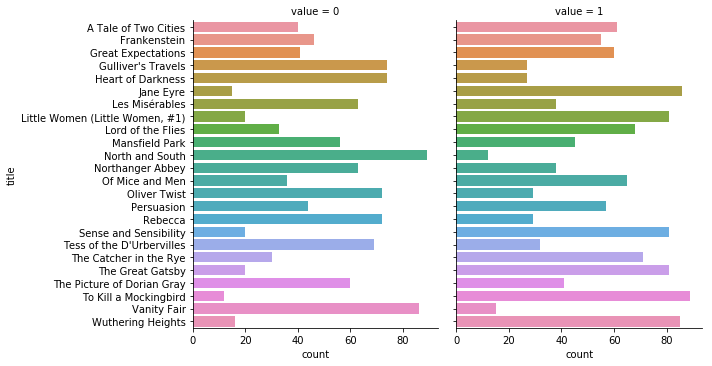

In [7]:
sns.catplot(x=None, y="title", col="value", kind="count",data=matrix_long); 

<h2 style="color:#088A68;">Singular Value Decomposition</h2>

In [22]:
print('\n------------Data------------------\n',data.shape,'\n------------------------------\n')
print('\n------------Rating------------------\n',ratings.shape,'\n------------------------------\n')
print('\n------------Data------------------\n',data.head(),'\n------------------------------\n')
print('\n------------Ratings------------------\n',ratings.head(),'\n------------------------------\n')
print('\n------------Book_tags------------------\n',book_tags.head(),'\n------------------------------\n')
print('\n------------Book------------------\n',books.head(),'\n------------------------------\n')


------------Data------------------
 (5976479, 5) 
------------------------------


------------Rating------------------
 (5976479, 3) 
------------------------------


------------Data------------------
    book_id  user_id  rating          authors  \
0        1     2886       5  Suzanne Collins   
1        1     6158       5  Suzanne Collins   
2        1     3991       4  Suzanne Collins   
3        1     5281       5  Suzanne Collins   
4        1     5721       5  Suzanne Collins   

                                     title  
0  The Hunger Games (The Hunger Games, #1)  
1  The Hunger Games (The Hunger Games, #1)  
2  The Hunger Games (The Hunger Games, #1)  
3  The Hunger Games (The Hunger Games, #1)  
4  The Hunger Games (The Hunger Games, #1)   
------------------------------


------------Ratings------------------
    user_id  book_id  rating
0        1      258       5
1        2     4081       4
2        2      260       5
3        2     9296       5
4        2     2318    

In [67]:
data.head()
data.shape
# data.pivot_table(index='user_id', columns='title', values='rating', aggfunc='count', fill_value=0)

(5976479, 5)

In [141]:
subset.head()

user_id  book_id                  title  \
0    44127      230             Persuasion   
1    44127       76  Sense and Sensibility   
2    44127       63      Wuthering Heights   
3    44127       43              Jane Eyre   
4    44127      160     Great Expectations   

                                           authors  rating  
0  Jane Austen, James Kinsley, Deidre Shauna Lynch       4  
1          Jane Austen, Tony Tanner, Ros Ballaster       4  
2                    Emily Brontë, Richard J. Dunn       4  
3                  Charlotte Brontë, Michael Mason       4  
4                                  Charles Dickens       5

In [35]:
matrix.shape, matrix_long.shape

((101, 25), (2424, 3))

In [142]:
 All_Data = subset[['user_id','title','rating']]
# All_Data = matrix_long
All_Data.head()

user_id                  title  rating
0    44127             Persuasion       4
1    44127  Sense and Sensibility       4
2    44127      Wuthering Heights       4
3    44127              Jane Eyre       4
4    44127     Great Expectations       5

In [143]:
# Create a reader 
# This tells our SVD about the upper and lower limit of the rating 
# The rating of the book is from 1 - 5 
max(data.rating)
reader = Reader(rating_scale=(1,5))

In [243]:
# Rebuild dataset for SVD using Reader 
# Dataframe is kept in order of User,Book,Rating

SVD_df = Dataset.load_from_df(All_Data,reader)
train_set, test_set = train_test_split(SVD_df,test_size=.10)

In [145]:
# Train a SVD Model with 5 Latent factor 
#Latetnt feature matrix created 
svd_model = SVD(n_factors=5)
svd_model.fit(train_set)

In [146]:
svd_model.qi.shape

(25, 5)

In [147]:
svd_model.pu.shape

(101, 5)

In [148]:
svd_model.trainset

In [149]:
# In SVD every item is link to an number, by using _raw2inner_id_items 
# we can see the correspoding ID of the Item i.e. Book

type(svd_model.trainset._raw2inner_id_items)
# Dict for Item from latent feature 
idx_item_d = svd_model.trainset._raw2inner_id_items

#Dict for User from latent feature 
idx_user_d =svd_model.trainset._raw2inner_id_users

In [523]:
# dataframe of book with latent Feature ID
idx_book = pd.DataFrame(idx_item_d.items(), columns=['Book_Title', 'Book_Feature_Id'])
idx_book.head()

Book_Title  Book_Feature_Id
0          Lord of the Flies                0
1               Frankenstein                1
2           Northanger Abbey                2
3      To Kill a Mockingbird                3
4  Tess of the D'Urbervilles                4

In [524]:
# dataframe of User with latent Feature ID
idx_user = pd.DataFrame(idx_user_d.items(), columns=['User', 'User_Feature_Id'])
idx_user.head()

User  User_Feature_Id
0  44179                0
1   8706                1
2  46038                2
3  44487                3
4  35855                4

In [526]:
# let find the latent feature vector for 'A Christmas Carol'

print (idx_item_d.get('Frankenstein'))
idx_book[idx_book.Book_Title=="Frankenstein"]



1


Book_Title  Book_Feature_Id
1  Frankenstein                1

In [527]:
# Now lets find latent feature for this 'Frankenstein' which at index of 1 of feature latent matrix 


print("Each book has {} latent features.".format(svd_model.qi[1].shape[0]))
svd_model.qi[1]

Each book has 5 latent features.


array([-0.08700427, -0.01097587,  0.00279779,  0.06274833,  0.03786686])

In [528]:
rating_matrix = All_Data.pivot_table(index='user_id', columns='title', values='rating', fill_value=0)
rating_matrix.head(5)


title    A Christmas Carol  A Tale of Two Cities  Frankenstein  \
user_id                                                          
929                      3                     4             0   
947                      4                     2             0   
1085                     5                     5             0   
1139                     0                     4             5   
1162                     0                     0             0   

title    Great Expectations  Gulliver's Travels  Heart of Darkness  Jane Eyre  \
user_id                                                                         
929                       4                   0                  0          0   
947                       3                   2                  0          4   
1085                      4                   5                  0          0   
1139                      3                   0                  3          3   
1162                      3                   3                  0          4   

title    Les Misérables  Little Women (Little Women, #1)  Lord of the Flies  \
user_id                                                                       
929                   0                                4                  4   
947                   0                                4                  4   
1085                  4                                5                  0   
1139                  0                                4                  4   
1162                  0                                4                  0   

title    ...  Persuasion  Rebecca  Sense and Sensibility  \
user_id  ...                                               
929      ...           0        0                      0   
947      ...           0        0                      0   
1085     ...           0        0                      4   
1139     ...           0        0                      0   
1162     ...           5        0                      4   

title    Tess of the D'Urbervilles  The Catcher in the Rye  The Great Gatsby  \
user_id                                                                        
929                              0                       5                 5   
947                              1                       0                 5   
1085                             4                       0                 3   
1139                             0                       5                 5   
1162                             1                       3                 5   

title    The Picture of Dorian Gray  To Kill a Mockingbird  Vanity Fair  \
user_id                                                                   
929                               4                      5            4   
947                               0                      0            0   
1085                              4                      5            0   
1139                              0                      5            0   
1162                              0                      2            0   

title    Wuthering Heights  
user_id                     
929                      4  
947                      3  
1085                     4  
1139                     5  
1162                     2  

[5 rows x 25 columns]

In [530]:
# checking Predicted rating Vs Actaul Rating of the Book
def get_book_rating(svdModel,MainData,tuser,tbook):
    act_Rate = MainData[( MainData['title'] == tbook ) & (All_Data['user_id'] == int(tuser))].rating
    return act_Rate, svdModel.predict(tuser,tbook)


In [533]:
test_user = '947'
test_book ="Gulliver's Travels"

# All_Data[( All_Data['title'] == 'Gulliver\'s Travels' ) & (All_Data['user_id'] == int(test_user))].rating

check  , result = get_book_rating(svd_model,All_Data,'947','Gulliver\'s Travels')
print('Actual Rating: {}'. format(check.values[0]))
print(result)

Actual Rating: 2
user: 947        item: Gulliver's Travels r_ui = None   est = 3.66   {'was_impossible': False}


In [531]:

check  , result = get_book_rating(svd_model,All_Data,'947','Jane Eyre')
print('Actual Rating: {}'. format(check.values[0]))
print(result)

Actual Rating: 4
user: 947        item: Jane Eyre  r_ui = None   est = 4.15   {'was_impossible': False}


In [499]:
# Perfrom the test on test_set using the Model svd_model with 5 latent Feature
predictions = svd_model.test(test_set)

# check the RMSE for the test set using the SVD model
print("User-based Model : Test Set")
accuracy.rmse(predictions, verbose=True)

User-based Model : Test Set
RMSE: 0.8703


0.8702524134105332

In [534]:
avg_rmse=[]

for i in range(100):
    train_set, test_set = train_test_split(SVD_df,test_size=.90)
    predictions = svd_model.test(test_set)
    # check the RMSE for the test set using the SVD model
    # print("User-based Model : Test Set")
    avg_rmse.append(accuracy.rmse(predictions, verbose=False))

def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)


mean(avg_rmse)

0.8453673772641248

In [535]:
# Using Cosine similarty among the vector find similar Book
from scipy import spatial

idx_item_d.get('A Christmas Carol')

vector_book1 = svd_model.qi[idx_item_d.get('A Christmas Carol')]
print('Latent vector for Book {} : {}'.format('A Christmas Carol',vector_book1))
vector_book2 = svd_model.qi[idx_item_d.get('Frankenstein')]
print('Latent vector for Book {} : {}'.format('Frankenstein',vector_book1))

# Cosine Distance 
vector_cosine =1-spatial.distance.cosine(vector_book1,vector_book2)
print('Cosine similarlity for Latent vector for Book {} {}: {}'.format('A Christmas Carol','Of Mice and Men',vector_cosine))



Latent vector for Book A Christmas Carol : [-0.04344973 -0.01631608 -0.0375891   0.04799348  0.18516167]
Latent vector for Book Frankenstein : [-0.04344973 -0.01631608 -0.0375891   0.04799348  0.18516167]
Cosine similarlity for Latent vector for Book A Christmas Carol Of Mice and Men: 0.6057669289232794


In [536]:
len(idx_book.Book_Title)


25

In [537]:
# # Here we are listing all the book and corresponding cosine similarty with all the other book
# Cosine similarity of movies latent feature vector 
# items_dic

items_dic = {}
len(svd_model.qi)
for i in range (len(idx_book.Book_Title)):
    cosine = {}
    vect1_book = [i for i in svd_model.qi[idx_item_d.get(idx_book.Book_Title[i])]]
#     items_dic[idx_book.Book_Title[i]] = vect1_book  
    for k in range (len(svd_model.qi)):
        cosine[idx_book.Book_Title[k]] = 1- spatial.distance.cosine(vect1_book,svd_model.qi[k])
#         cosine[(1- spatial.distance.cosine(vect1_book,svd_model.qi[k]))] =  idx_book.Book_Title[k]
    sorted_x = sorted(cosine.items(), key=lambda kv: kv[1],reverse=True)
    items_dic[idx_book.Book_Title[i]] = sorted_x  
    

# Method to show N item from Dict
def show_dict_item(n, dict_obj):
    return {k: dict_obj[k] for k in list(dict_obj)[:n]}

# build Final Recommendation by Book Title 
# Not Dropping the books already read by user 
def get_book_recommendation(title,number_of_rec=5):
    Rec_Order = items_dic.get(title)
    return Rec_Order[1:6]


print(show_dict_item(2,items_dic))


{'Lord of the Flies': [('Lord of the Flies', 1.0), ('The Great Gatsby', 0.8847121458585455), ('Northanger Abbey', 0.8313725398220007), ('Little Women (Little Women, #1)', 0.6565470023311372), ('North and South', 0.6563189347581183), ('Rebecca', 0.6391315410041709), ('Great Expectations', 0.6247231073824923), ('Oliver Twist', 0.5391081278037034), ('Sense and Sensibility', 0.48255817115519006), ('Vanity Fair', 0.38563293634655227), ('Mansfield Park', 0.30072603929753894), ('A Tale of Two Cities', 0.2729970740715041), ("Tess of the D'Urbervilles", 0.12534898657723725), ('Persuasion', 0.11090407976057881), ('Heart of Darkness', 0.06938551294579443), ('A Christmas Carol', -0.026839064576001048), ('To Kill a Mockingbird', -0.1420922300857459), ('Wuthering Heights', -0.20287109007022308), ('Frankenstein', -0.21432525931727175), ('Jane Eyre', -0.2381588151191123), ('Les Misérables', -0.4468234284047985), ("Gulliver's Travels", -0.6599238568102095), ('Of Mice and Men', -0.6788873045365857), ('T

In [538]:
# Recommend top 5 book by Book Title 'Lord of the Flies'
get_book_recommendation('Lord of the Flies')

[('The Great Gatsby', 0.8847121458585455),
 ('Northanger Abbey', 0.8313725398220007),
 ('Little Women (Little Women, #1)', 0.6565470023311372),
 ('North and South', 0.6563189347581183),
 ('Rebecca', 0.6391315410041709)]

In [520]:
get_book_recommendation('Frankenstein')

[('Vanity Fair', 0.7229500898244776),
 ('A Christmas Carol', 0.6057669289232794),
 ('Les Misérables', 0.2446308279121574),
 ('Great Expectations', 0.211009855979285),
 ('North and South', 0.20200605761962542)]

In [541]:
#to get the Dict from item_dic dict for movie 'Frankenstein'
Rec_Order = items_dic.get('Frankenstein')
Rec_Order

[('Frankenstein', 1.0),
 ('Vanity Fair', 0.7229500898244776),
 ('A Christmas Carol', 0.6057669289232794),
 ('Les Misérables', 0.2446308279121574),
 ('Great Expectations', 0.211009855979285),
 ('North and South', 0.20200605761962542),
 ('A Tale of Two Cities', 0.19647594222740794),
 ('Oliver Twist', 0.11258693137192377),
 ('The Picture of Dorian Gray', 0.05446954657547931),
 ('Jane Eyre', -0.08469077070126874),
 ('Persuasion', -0.14036701335749258),
 ('The Great Gatsby', -0.18772479175609447),
 ('Lord of the Flies', -0.21432525931727175),
 ('Heart of Darkness', -0.22823120376253025),
 ('The Catcher in the Rye', -0.2839132235085342),
 ('Rebecca', -0.3235187273305371),
 ('Little Women (Little Women, #1)', -0.32560227459499935),
 ('Of Mice and Men', -0.3404981577818924),
 ("Tess of the D'Urbervilles", -0.39350512571676566),
 ('Sense and Sensibility', -0.4266106349777794),
 ("Gulliver's Travels", -0.45120587241497123),
 ('Northanger Abbey', -0.562960545095994),
 ('To Kill a Mockingbird', -0

<h2 style="color:#088A68;">Alternating Least Squares Method</h2>
In case we choose to explore ALS technique as well ^^

<h2 style="color:#088A68;">Surprise!</h2>

<h2 style="color:#088A68;">Analysis</h2>

---
#### References: 
*  **[Goodbooks-10k:](http://fastml.com/goodbooks-10k-a-new-dataset-for-book-recommendations/)** A New Dataset for Book Recommendations